# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## 0 - Importing libraries and Creating a Spark Session

In [1]:
### Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split
from pyspark.sql.functions import udf, isnull,  when, regexp_replace, datediff, regexp_replace
from pyspark.sql.types import IntegerType, BooleanType,DateType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,\
DecisionTreeClassifier, NaiveBayes, LinearSVC

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover,\
StringIndexer, VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Creating a Spark session
spark = SparkSession.builder.appName("Sparkify_Udacity").getOrCreate()

## 1 - Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### 1.1 - Visualizing the data structure and checking columns

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
### Visualizing the first 5 rows
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
### Getting the list of column names
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [6]:
### Printing the Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
### Checking some metrics for numerical columns
df.select([col[0] for col in df.dtypes if col[1] != 'string']).describe().show()

+-------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|        sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+
|  count|            286500|           228108|              278154|           286500|            286500|              286500|
|   mean|114.41421291448516|249.1171819778458|1.535358834084427...|1041.526554973822|210.05459685863875|1.540956889810483...|
| stddev|129.76726201140994|99.23517921058361| 3.291321616327586E9|726.7762634630741| 31.50507848842214|1.5075439608226302E9|
|    min|                 0|          0.78322|       1521380675000|                1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|             2474|               404|       1543799

In [8]:
### Selecting columns
df.select('userID', 'artist', 'auth', 'firstName', 'lastName', 'gender',
          'location', 'itemInSession', 'length', 'level','method').show(5)

+------+----------------+---------+---------+--------+------+--------------------+-------------+---------+-----+------+
|userID|          artist|     auth|firstName|lastName|gender|            location|itemInSession|   length|level|method|
+------+----------------+---------+---------+--------+------+--------------------+-------------+---------+-----+------+
|    30|  Martha Tilston|Logged In|    Colin| Freeman|     M|     Bakersfield, CA|           50|277.89016| paid|   PUT|
|     9|Five Iron Frenzy|Logged In|    Micah|    Long|     M|Boston-Cambridge-...|           79|236.09424| free|   PUT|
|    30|    Adam Lambert|Logged In|    Colin| Freeman|     M|     Bakersfield, CA|           51| 282.8273| paid|   PUT|
|     9|          Enigma|Logged In|    Micah|    Long|     M|Boston-Cambridge-...|           80|262.71302| free|   PUT|
|    30|       Daft Punk|Logged In|    Colin| Freeman|     M|     Bakersfield, CA|           52|223.60771| paid|   PUT|
+------+----------------+---------+-----

In [9]:
### Selecting the remaining columns
df.select('page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent').show(5)

+--------+-------------+---------+--------------------+------+-------------+--------------------+
|    page| registration|sessionId|                song|status|           ts|           userAgent|
+--------+-------------+---------+--------------------+------+-------------+--------------------+
|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|
|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|
|NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|
|NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|
|NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|
+--------+-------------+---------+--------------------+------+-------------+--------------------+
only showing top 5 rows



In [10]:
### Checking unique values for a few colunms
for col in ['auth', 'gender', 'level', 'method', 'page', 'status', 'userAgent']:
    df.select(col).distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (M

### 1.2 - Looking for null and blank User IDs

In [11]:
### Getting the shape of the dataframe
df.toPandas().shape

(286500, 18)

In [12]:
### Looking for columns containing null values
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [13]:
### Doing a row count
df.toPandas().count()

artist           228108
auth             286500
firstName        278154
gender           278154
itemInSession    286500
lastName         278154
length           228108
level            286500
location         278154
method           286500
page             286500
registration     278154
sessionId        286500
song             228108
status           286500
ts               286500
userAgent        278154
userId           286500
dtype: int64

In [14]:
### Filtering based on non-null values
df = df.filter(df.userId != "")

In [15]:
### Doing a row count after the filtering
df.toPandas().count()

artist           228108
auth             278154
firstName        278154
gender           278154
itemInSession    278154
lastName         278154
length           228108
level            278154
location         278154
method           278154
page             278154
registration     278154
sessionId        278154
song             228108
status           278154
ts               278154
userAgent        278154
userId           278154
dtype: int64

## 2 - Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### 2.1 - Defining Churn

In [16]:
### Counting the total number of transactions
df.select('userId').count()

278154

In [17]:
### Counting the number of unique users
df.select('userId').dropDuplicates().count()

225

In [18]:
### Checking the distinct values for the column page
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [19]:
### Creating time-related functions
time_stamp      = udf(lambda col: datetime.datetime.fromtimestamp(col/1000).strftime('%Y-%m-%d %H:%M:%S'))
extract_hour    = udf(lambda col: datetime.datetime.fromtimestamp(col/1000).hour)
extract_day     = udf(lambda col: datetime.datetime.fromtimestamp(col/1000).day)
extract_weekday = udf(lambda col: datetime.datetime.fromtimestamp(col/1000).strftime('%w'))
extract_month   = udf(lambda col: datetime.datetime.fromtimestamp(col/1000).month)


### Applying functions
df = df.withColumn('access_date', time_stamp(df.ts))
df = df.withColumn('access_hour', extract_hour(df.ts))
df = df.withColumn('access_day', extract_day(df.ts))
df = df.withColumn('access_weekday', extract_weekday(df.ts))
df = df.withColumn('access_month', extract_month(df.ts))

In [20]:
### Checking the data after creating time-related columns
df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,access_date,access_hour,access_day,access_weekday,access_month
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,0,1,1,10
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,0,1,1,10
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,0,1,1,10
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,0,1,1,10
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,0,1,1,10


In [21]:
### Creating the churn column by flagging the column page
flag = udf(lambda col: 1 if col == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', flag('page'))

In [22]:
### Getting a list of cancelled Ids
cancelled_ids = df.select('userId', 'churn').filter(df.churn ==1).sort('userId').withColumnRenamed('churn', 'new_churn')

In [23]:
### Merging cancelled ids with the original dataframe
df = df.join(cancelled_ids, on=['userId'], how='left').drop('churn').withColumnRenamed('new_churn', 'churn')

In [24]:
### Replacing nulls with zero
df = df.na.fill(value=0,subset=['churn'])

In [25]:
### Doing a count for the churn column
df.toPandas()['churn'].value_counts()

0    233290
1     44864
Name: churn, dtype: int64

In [26]:
### Checking an Id that is still active
df.filter(df.userId == 10).toPandas().head(800)

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,song,status,ts,userAgent,access_date,access_hour,access_day,access_weekday,access_month,churn
0,10,Sea Wolf,Logged In,Brycen,M,0,Bradley,265.53424,paid,"Laurel, MS",...,Ses Monuments,200,1538965220000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:20:20,2,8,1,10,0
1,10,George Baker Selection,Logged In,Brycen,M,1,Bradley,200.43710,paid,"Laurel, MS",...,Morning Sky,200,1538965485000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:24:45,2,8,1,10,0
2,10,Klaus Lage,Logged In,Brycen,M,2,Bradley,208.03873,paid,"Laurel, MS",...,Du Hast'n Freund In Mir (You've Got A Friend I...,200,1538965685000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:28:05,2,8,1,10,0
3,10,Dave Grusin,Logged In,Brycen,M,3,Bradley,526.44526,paid,"Laurel, MS",...,Playera,200,1538965893000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:31:33,2,8,1,10,0
4,10,Blue Oyster Cult,Logged In,Brycen,M,4,Bradley,272.06485,paid,"Laurel, MS",...,Burnin' For You,200,1538966419000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:40:19,2,8,1,10,0
5,10,Lifehouse,Logged In,Brycen,M,5,Bradley,207.01995,paid,"Laurel, MS",...,Sky Is Falling,200,1538966691000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:44:51,2,8,1,10,0
6,10,Camper Van Beethoven,Logged In,Brycen,M,6,Bradley,106.31791,paid,"Laurel, MS",...,Skinhead Stomp,200,1538966898000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:48:18,2,8,1,10,0
7,10,None,Logged In,Brycen,M,7,Bradley,NaN,paid,"Laurel, MS",...,None,307,1538966899000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:48:19,2,8,1,10,0
8,10,Dwight Yoakam,Logged In,Brycen,M,8,Bradley,239.30730,paid,"Laurel, MS",...,You're The One,200,1538967004000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:50:04,2,8,1,10,0
9,10,Matthew Good Band,Logged In,Brycen,M,9,Bradley,264.85506,paid,"Laurel, MS",...,Strange Days,200,1538967243000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:54:03,2,8,1,10,0


In [27]:
### Checking an Id that has been cancelled
df.filter(df.userId == 100001).toPandas().head(200)

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,song,status,ts,userAgent,access_date,access_hour,access_day,access_weekday,access_month,churn
0,100001,None,Logged In,Delaney,F,0,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,None,200,1538376504000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 06:48:24,6,1,1,10,1
1,100001,Lady GaGa / Colby O'Donis,Logged In,Delaney,F,1,Perez,238.54975,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Just Dance,200,1538376509000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 06:48:29,6,1,1,10,1
2,100001,None,Logged In,Delaney,F,2,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,None,200,1538376542000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 06:49:02,6,1,1,10,1
3,100001,Gorillaz,Logged In,Delaney,F,3,Perez,602.17424,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Kids With Guns (Quiet Village Remix),200,1538376747000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 06:52:27,6,1,1,10,1
4,100001,None,Logged In,Delaney,F,4,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,None,200,1538376783000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 06:53:03,6,1,1,10,1
5,100001,Far Corner,Logged In,Delaney,F,5,Perez,399.88200,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Do You Think I'm Spooky?,200,1538377349000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 07:02:29,7,1,1,10,1
6,100001,The Replacements,Logged In,Delaney,F,6,Perez,184.60689,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Can't Hardly Wait (Remastered Version),200,1538377748000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 07:09:08,7,1,1,10,1
7,100001,Pendulum,Logged In,Delaney,F,7,Perez,313.86077,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Propane Nightmares,200,1538377932000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 07:12:12,7,1,1,10,1
8,100001,Tyrone Wells,Logged In,Delaney,F,8,Perez,238.65424,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Falling,200,1538378245000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 07:17:25,7,1,1,10,1
9,100001,3 Doors Down,Logged In,Delaney,F,9,Perez,204.32934,free,"Miami-Fort Lauderdale-West Palm Beach, FL",...,Runaway,200,1538378483000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",2018-10-01 07:21:23,7,1,1,10,1


In [28]:
### Comparing datetime columns
df.select('ts', 'access_date').show(5)

+-------------+-------------------+
|           ts|        access_date|
+-------------+-------------------+
|1539003534000|2018-10-08 12:58:54|
|1539003736000|2018-10-08 13:02:16|
|1539003932000|2018-10-08 13:05:32|
|1539003933000|2018-10-08 13:05:33|
|1539004195000|2018-10-08 13:09:55|
+-------------+-------------------+
only showing top 5 rows



In [29]:
df.select('page', 'churn').filter(df.page=='Cancellation Confirmation').show(5)

+--------------------+-----+
|                page|churn|
+--------------------+-----+
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
+--------------------+-----+
only showing top 5 rows



In [30]:
### Sorting dataframe by UserID and access_date
df = df.select([col for col in df.columns]).sort('UserID', 'access_date')
df.toPandas().head()

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,song,status,ts,userAgent,access_date,access_hour,access_day,access_weekday,access_month,churn
0,10,Sea Wolf,Logged In,Brycen,M,0,Bradley,265.53424,paid,"Laurel, MS",...,Ses Monuments,200,1538965220000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:20:20,2,8,1,10,0
1,10,George Baker Selection,Logged In,Brycen,M,1,Bradley,200.43710,paid,"Laurel, MS",...,Morning Sky,200,1538965485000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:24:45,2,8,1,10,0
2,10,Klaus Lage,Logged In,Brycen,M,2,Bradley,208.03873,paid,"Laurel, MS",...,Du Hast'n Freund In Mir (You've Got A Friend I...,200,1538965685000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:28:05,2,8,1,10,0
3,10,Dave Grusin,Logged In,Brycen,M,3,Bradley,526.44526,paid,"Laurel, MS",...,Playera,200,1538965893000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:31:33,2,8,1,10,0
4,10,Blue Oyster Cult,Logged In,Brycen,M,4,Bradley,272.06485,paid,"Laurel, MS",...,Burnin' For You,200,1538966419000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2018-10-08 02:40:19,2,8,1,10,0


In [31]:
### Converting to a Pandas dataframe
df2 = df.toPandas()


### Reordering columns
df2 = df2[['userId', 'artist', 'auth', 'firstName', 'lastName',
           'gender','location','itemInSession', 'length', 'level',
           'method','page', 'registration', 'sessionId', 'song',
           'status', 'userAgent', 'ts', 'access_date', 'access_hour',
           'access_day', 'access_weekday', 'access_month', 'churn']]

df2.head(5)

,userId,artist,auth,firstName,lastName,gender,location,itemInSession,length,level,...,song,status,userAgent,ts,access_date,access_hour,access_day,access_weekday,access_month,churn
0,10,Sea Wolf,Logged In,Brycen,Bradley,M,"Laurel, MS",0,265.53424,paid,...,Ses Monuments,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965220000,2018-10-08 02:20:20,2,8,1,10,0
1,10,George Baker Selection,Logged In,Brycen,Bradley,M,"Laurel, MS",1,200.43710,paid,...,Morning Sky,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965485000,2018-10-08 02:24:45,2,8,1,10,0
2,10,Klaus Lage,Logged In,Brycen,Bradley,M,"Laurel, MS",2,208.03873,paid,...,Du Hast'n Freund In Mir (You've Got A Friend I...,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965685000,2018-10-08 02:28:05,2,8,1,10,0
3,10,Dave Grusin,Logged In,Brycen,Bradley,M,"Laurel, MS",3,526.44526,paid,...,Playera,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965893000,2018-10-08 02:31:33,2,8,1,10,0
4,10,Blue Oyster Cult,Logged In,Brycen,Bradley,M,"Laurel, MS",4,272.06485,paid,...,Burnin' For You,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538966419000,2018-10-08 02:40:19,2,8,1,10,0


In [32]:
### Dropping duplicates and keeping last record
df_unique = df2.drop_duplicates(['userId'], keep='last')
df_unique.head(5)

,userId,artist,auth,firstName,lastName,gender,location,itemInSession,length,level,...,song,status,userAgent,ts,access_date,access_hour,access_day,access_weekday,access_month,churn
794,10,None,Logged In,Brycen,Bradley,M,"Laurel, MS",98,NaN,paid,...,None,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1542631788000,2018-11-19 12:49:48,12,19,1,11,0
4008,100,None,Logged In,Colin,Larson,M,"Dallas-Fort Worth-Arlington, TX",92,NaN,paid,...,None,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,1543587349000,2018-11-30 14:15:49,14,30,5,11,0
4195,100001,None,Cancelled,Delaney,Perez,F,"Miami-Fort Lauderdale-West Palm Beach, FL",23,NaN,free,...,None,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",1538498205000,2018-10-02 16:36:45,16,2,2,10,1
4413,100002,The Cure,Logged In,Gracie,Chang,F,"Santa Maria-Santa Barbara, CA",0,465.60608,paid,...,Lullaby,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1543799476000,2018-12-03 01:11:16,1,3,1,12,0
4491,100003,None,Cancelled,Nevaeh,Jones,F,"Miami-Fort Lauderdale-West Palm Beach, FL",81,NaN,free,...,None,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,1539274781000,2018-10-11 16:19:41,16,11,4,10,1


### 2.2 - Exploring Data

In [33]:
### Checking the churn count for unique users
df_unique['churn'].value_counts()

0    173
1     52
Name: churn, dtype: int64

In [34]:
### Splitting by state
new = df_unique['location'].str.split(',', expand=True)
new.columns = ['City', 'State']

### Appending to the original dataframe
df_unique = pd.concat([df_unique, new], axis=1)
df_unique.head(5)

,userId,artist,auth,firstName,lastName,gender,location,itemInSession,length,level,...,userAgent,ts,access_date,access_hour,access_day,access_weekday,access_month,churn,City,State
794,10,None,Logged In,Brycen,Bradley,M,"Laurel, MS",98,NaN,paid,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1542631788000,2018-11-19 12:49:48,12,19,1,11,0,Laurel,MS
4008,100,None,Logged In,Colin,Larson,M,"Dallas-Fort Worth-Arlington, TX",92,NaN,paid,...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,1543587349000,2018-11-30 14:15:49,14,30,5,11,0,Dallas-Fort Worth-Arlington,TX
4195,100001,None,Cancelled,Delaney,Perez,F,"Miami-Fort Lauderdale-West Palm Beach, FL",23,NaN,free,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",1538498205000,2018-10-02 16:36:45,16,2,2,10,1,Miami-Fort Lauderdale-West Palm Beach,FL
4413,100002,The Cure,Logged In,Gracie,Chang,F,"Santa Maria-Santa Barbara, CA",0,465.60608,paid,...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1543799476000,2018-12-03 01:11:16,1,3,1,12,0,Santa Maria-Santa Barbara,CA
4491,100003,None,Cancelled,Nevaeh,Jones,F,"Miami-Fort Lauderdale-West Palm Beach, FL",81,NaN,free,...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,1539274781000,2018-10-11 16:19:41,16,11,4,10,1,Miami-Fort Lauderdale-West Palm Beach,FL


In [35]:
### Converting the Pandas dataframe into a Pyspark dataframe
df_spark = spark.createDataFrame(df_unique)

In [36]:
df_spark.groupby(['churn', 'gender']).count().sort('churn').show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|     M|   89|
|    1|     M|   32|
|    1|     F|   20|
+-----+------+-----+



### 2.2.1 - Checking distributions

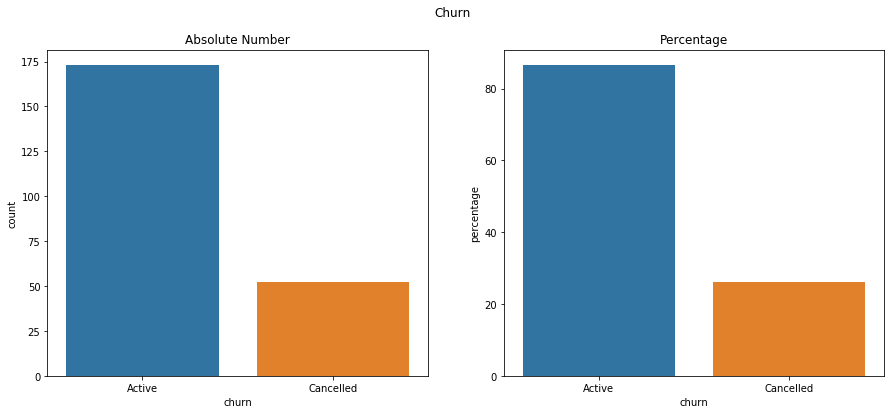

In [37]:
### Wrangling the data to be plotted
df_bar = df_spark.groupby(['churn']).count().sort('churn').toPandas()
df_bar['percentage']= df_bar['count']/df_bar.shape[0]
churnDict = {0:'Active', 1:'Cancelled'}
df_bar.churn = df_bar.churn.replace(churnDict)

### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('Churn')

### Plotting Churn Count
plt.subplot(121)
plt.title('Absolute Number')
sns.barplot(x='churn', y='count', data=df_bar)

### Plotting Churn Percentage
plt.subplot(122)
plt.title('Percentage')
sns.barplot(x='churn', y='percentage',  data=df_bar)

plt.show()

***Obs:***
Over 85% of users are active. We need to work on maximizing this rate

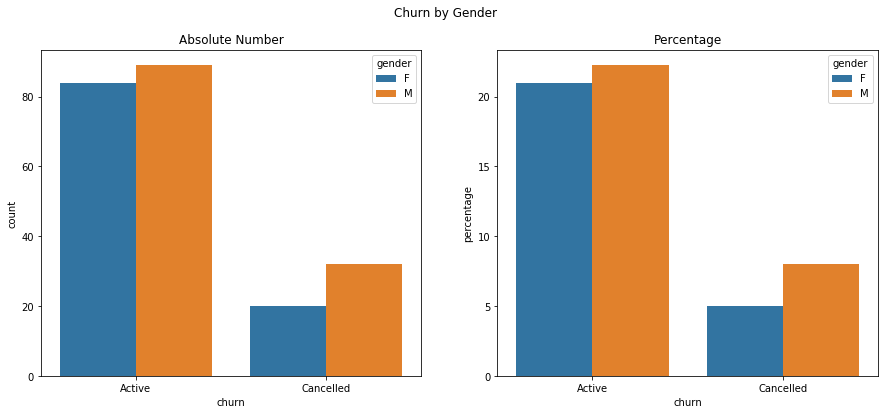

In [38]:
### Wrangling the data to be plotted
df_bar = df_spark.groupby(['churn', 'gender']).count().sort('churn').toPandas()
df_bar['percentage']= df_bar['count']/df_bar.shape[0]
churnDict = {0:'Active', 1:'Cancelled'}
df_bar.churn = df_bar.churn.replace(churnDict)

### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('Churn by Gender')

### Plotting Churn Count
plt.subplot(121)
plt.title('Absolute Number')
sns.barplot(x='churn', y='count', hue='gender', data=df_bar)

### Plotting Churn Percentage
plt.subplot(122)
plt.title('Percentage')
sns.barplot(x='churn', y='percentage', hue='gender', data=df_bar)

plt.show()

***Obs:***
It can be observed that the proportion of males x females among active users is almost 50/50, unlike cancelled users

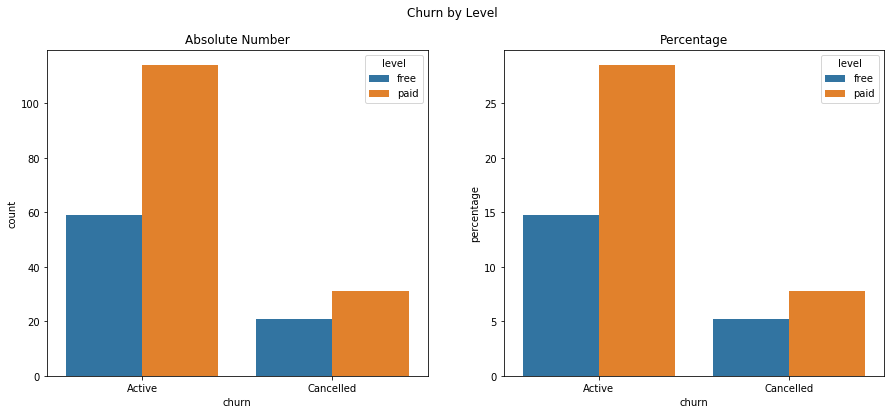

In [39]:
### Churn by level
df_bar = df_spark.groupby(['churn', 'level']).count().sort('churn').toPandas()
df_bar['percentage']= df_bar['count']/df_bar.shape[0]
churnDict = {0:'Active', 1:'Cancelled'}
df_bar.churn = df_bar.churn.replace(churnDict)

### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('Churn by Level')

### Plotting Churn Count
plt.subplot(121)
plt.title('Absolute Number')
sns.barplot(x='churn', y='count', hue='level', data=df_bar)

### Plotting Churn Percentage
plt.subplot(122)
plt.title('Percentage')
sns.barplot(x='churn', y='percentage', hue='level', data=df_bar)

plt.show()

***Obs:***
 It is interesting to observe that among active users, almost two thirds have paid accounts. When it comes to cancelled users, the proportion is more balanced

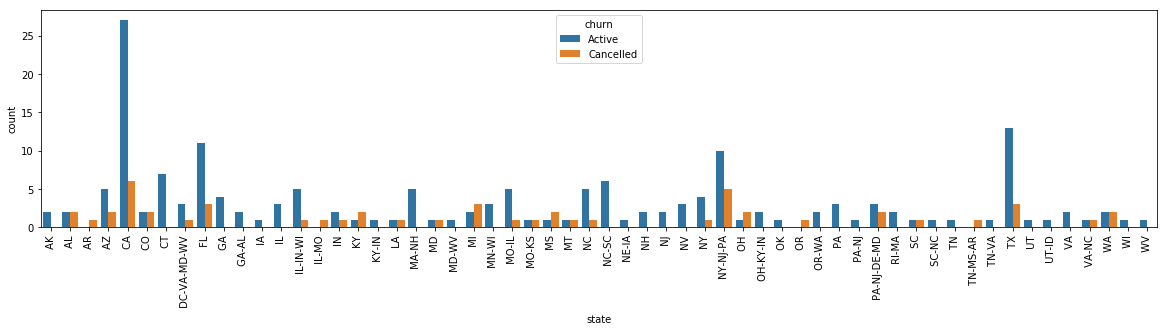

In [40]:
### Churn by state- Count
df_bar = df_spark.groupby(['state', 'churn']).count().sort('state').toPandas()
churnDict = {0:'Active', 1:'Cancelled'}
df_bar.churn = df_bar.churn.replace(churnDict)

plt.figure(figsize=(20, 4))
ax = sns.barplot(x='state', y='count', hue='churn', data=df_bar)
plt.xticks(rotation=90)
plt.show()

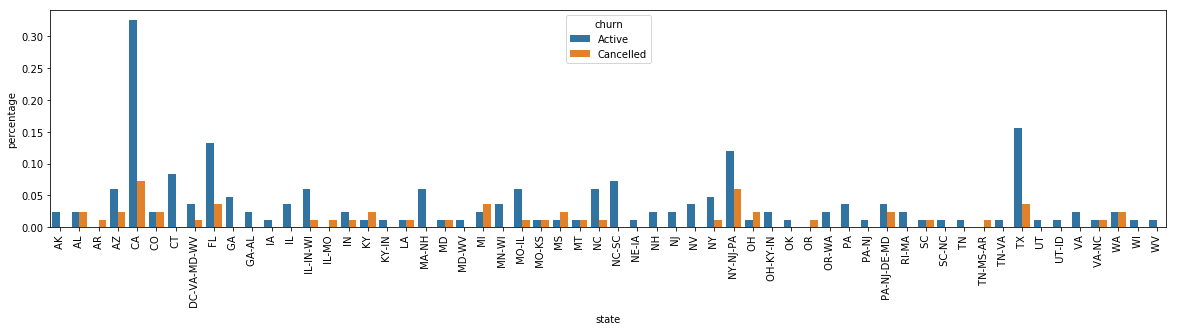

In [41]:
### Churn by state- Percentage
df_bar = df_spark.groupby(['state', 'churn']).count().sort('state').toPandas()
df_bar['percentage']= df_bar['count']/df_bar.shape[0]
churnDict = {0:'Active', 1:'Cancelled'}
df_bar.churn = df_bar.churn.replace(churnDict)

plt.figure(figsize=(20, 4))
ax = sns.barplot(x='state', y='percentage', hue='churn', data=df_bar)
plt.xticks(rotation=90)
plt.show()

***Obs:***
No wonder, California, Florida, Texas and the cluster New York-New Jersey-Pennsylvania are the states where the majority of user are from

### 2.2.2 - Comparing the two groups - Active x Cancelled

In [42]:
### Converting the Pandas dataframe into a Spark dataframe
df3 = spark.createDataFrame(df2)
df3.toPandas().head()

,userId,artist,auth,firstName,lastName,gender,location,itemInSession,length,level,...,song,status,userAgent,ts,access_date,access_hour,access_day,access_weekday,access_month,churn
0,10,Sea Wolf,Logged In,Brycen,Bradley,M,"Laurel, MS",0,265.53424,paid,...,Ses Monuments,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965220000,2018-10-08 02:20:20,2,8,1,10,0
1,10,George Baker Selection,Logged In,Brycen,Bradley,M,"Laurel, MS",1,200.43710,paid,...,Morning Sky,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965485000,2018-10-08 02:24:45,2,8,1,10,0
2,10,Klaus Lage,Logged In,Brycen,Bradley,M,"Laurel, MS",2,208.03873,paid,...,Du Hast'n Freund In Mir (You've Got A Friend I...,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965685000,2018-10-08 02:28:05,2,8,1,10,0
3,10,Dave Grusin,Logged In,Brycen,Bradley,M,"Laurel, MS",3,526.44526,paid,...,Playera,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538965893000,2018-10-08 02:31:33,2,8,1,10,0
4,10,Blue Oyster Cult,Logged In,Brycen,Bradley,M,"Laurel, MS",4,272.06485,paid,...,Burnin' For You,200,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1538966419000,2018-10-08 02:40:19,2,8,1,10,0


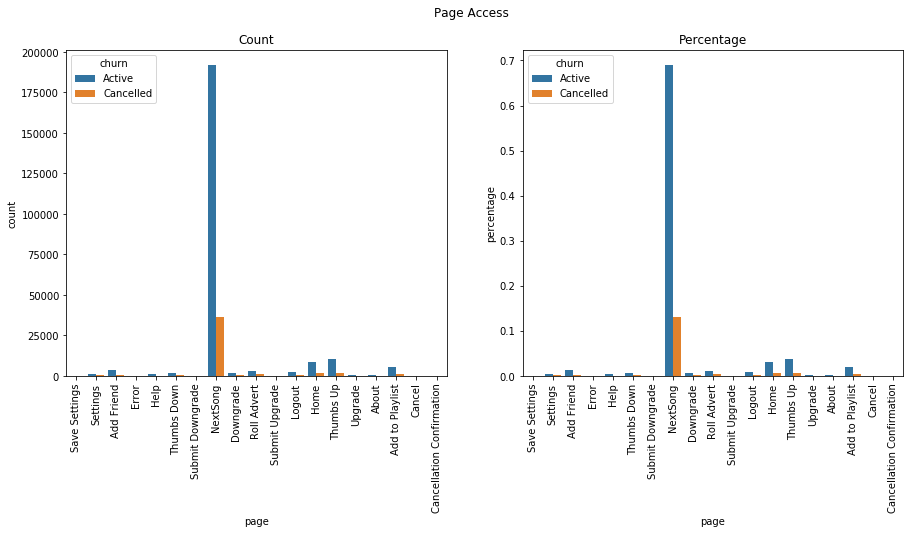

In [43]:
### Generating the plot with all pages
df_bar = df3.groupby(['churn', 'page']).count().sort('churn').toPandas()
df_bar['percentage']= df_bar['count']/df_bar['count'].sum()
churnDict = {0:'Active', 1:'Cancelled'}
df_bar.churn = df_bar.churn.replace(churnDict)

### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('Page Access')

### Plotting Churn Count
plt.subplot(121)
plt.title('Count')
sns.barplot(x='page', y='count', hue='churn', data=df_bar)
plt.xticks(rotation=90)

### Plotting Churn Percentage
plt.subplot(122)
plt.title('Percentage')
sns.barplot(x='page', y='percentage', hue='churn', data=df_bar)
plt.xticks(rotation=90)

plt.show()

***Obs:***
It is interesting to observe how 'NextSong' stands out when compared to the other pages. We need to create a plot without this page to see how the other pages are distributed

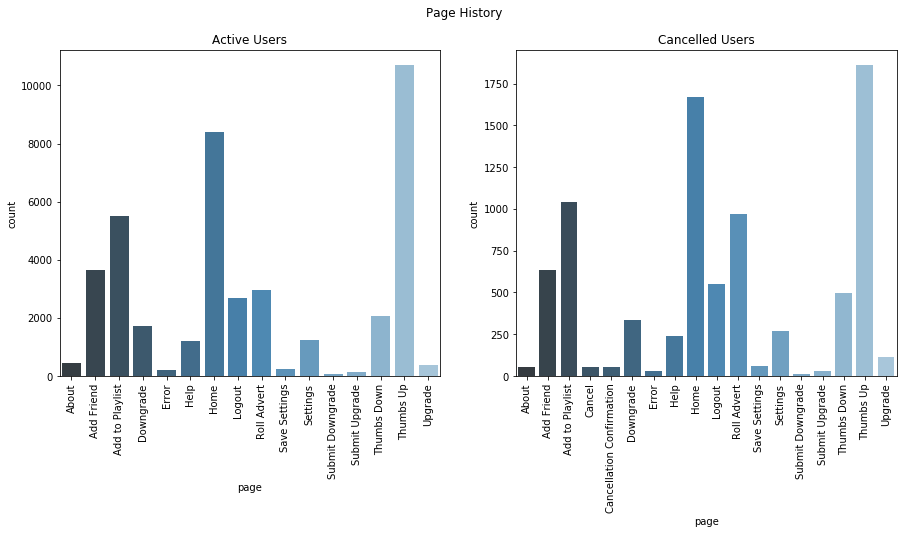

In [44]:
### Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page != 'NextSong').filter(df3.churn==0).groupby(['churn', 'page']).count().\
sort('page').toPandas()


df_bar_1 = df3.filter(df3.page != 'NextSong').filter(df3.churn==1).groupby(['churn', 'page']).count().\
sort('page').toPandas()


### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('Page History')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
plt.xticks(rotation=90)
sns.barplot(x='page', y='count', palette="Blues_d", data=df_bar_0)

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
plt.xticks(rotation=90)
sns.barplot(x='page', y='count', palette="Blues_d", data=df_bar_1)

plt.show()

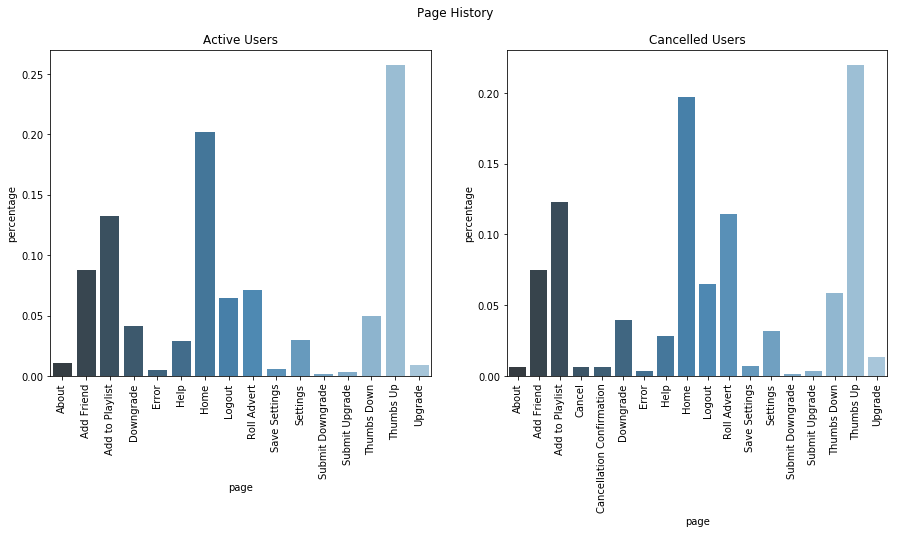

In [45]:
### Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page != 'NextSong').filter(df3.churn==0).groupby(['churn', 'page']).count().\
sort('page').toPandas()
df_bar_0['percentage']= df_bar_0['count']/df_bar_0['count'].sum()

df_bar_1 = df3.filter(df3.page != 'NextSong').filter(df3.churn==1).groupby(['churn', 'page']).count().\
sort('page').toPandas()
df_bar_1['percentage']= df_bar_1['count']/df_bar_1['count'].sum()


### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('Page History')


### Plotting active users
plt.subplot(121)
plt.title('Active Users')
plt.xticks(rotation=90)
sns.barplot(x='page', y='percentage', palette="Blues_d", data=df_bar_0)

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
plt.xticks(rotation=90)
sns.barplot(x='page', y='percentage', palette="Blues_d", data=df_bar_1)

plt.show()

***Obs:***
The distribution of pages is very similar when we compare Active and Cancelled users. Thumbs-up comes first, followed by Home, and Add to Playlist. The difference is that, for Active users, the 4th most visited page is Add Friend, whereas for Cancelled users is Roll Advert. Other than that, both distributions look very similar.

### Time Series Analysis - Without page Next Song

In [46]:
### Converting column type to integer
df3 = df3.withColumn("access_hour",df3.access_hour.cast('int')).\
          withColumn("access_day",df3.access_day.cast('int')).\
          withColumn("access_weekday",df3.access_weekday.cast('int'))

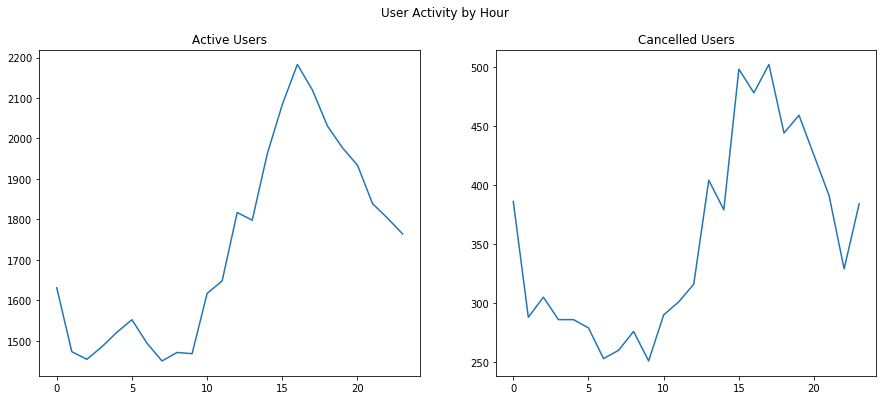

In [47]:
### Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page != 'NextSong').filter(df3.churn==0).groupBy(['access_hour']).count().\
sort('access_hour').toPandas()


df_bar_1 = df3.filter(df3.page != 'NextSong').filter(df3.churn==1).groupBy(['access_hour']).count().\
sort('access_hour').toPandas()



### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('User Activity by Hour')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
#sns.barplot(x='access_hour', y='count', palette="Blues_d", data=df_bar_0)
plt.plot(df_bar_0['access_hour'], df_bar_0['count'])

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
#sns.barplot(x='access_hour', y='count', palette="Blues_d", data=df_bar_1)
plt.plot(df_bar_1['access_hour'], df_bar_1['count'])

plt.show()

***Obs:***
Both active and cancelled users are more active in the aftenoon. However, it is visible that the active users curve is more linear

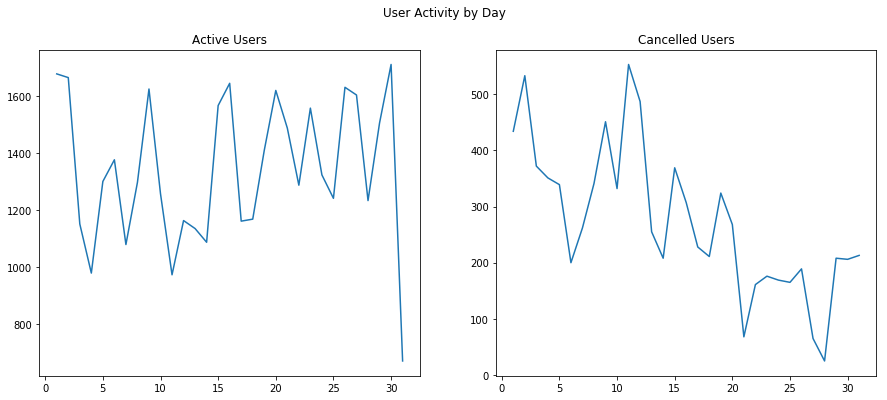

In [48]:
### Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page != 'NextSong').filter(df3.churn==0).groupBy(['access_day']).count().\
sort('access_day').toPandas()


df_bar_1 = df3.filter(df3.page != 'NextSong').filter(df3.churn==1).groupBy(['access_day']).count().\
sort('access_day').toPandas()



### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('User Activity by Day')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
plt.plot(df_bar_0['access_day'], df_bar_0['count'])
#sns.barplot(x='access_day', y='count', palette="Blues_d", data=df_bar_0)

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
plt.plot(df_bar_1['access_day'], df_bar_1['count'])
#sns.barplot(x='access_day', y='count', palette="Blues_d", data=df_bar_1)

plt.show()

***Obs:***
It is interesting to observe the difference between groups. While Active users have a more stable behaviour throughout the month, Cancelled users use to access more in the first 10 days of the month and then, it tends to plummet.

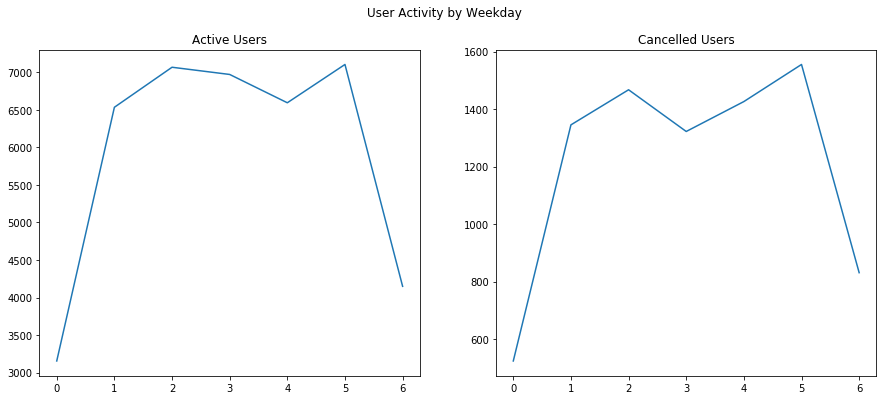

In [49]:
### Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page != 'NextSong').filter(df3.churn==0).groupBy(['access_weekday']).count().\
sort('access_weekday').toPandas()


df_bar_1 = df3.filter(df3.page != 'NextSong').filter(df3.churn==1).groupBy(['access_weekday']).count().\
sort('access_weekday').toPandas()



### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('User Activity by Weekday')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
plt.plot(df_bar_0['access_weekday'], df_bar_0['count'])
#sns.barplot(x='access_weekday', y='count', palette="Blues_d", data=df_bar_0)

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
plt.plot(df_bar_1['access_weekday'], df_bar_1['count'])
#sns.barplot(x='access_weekday', y='count', palette="Blues_d", data=df_bar_1)

plt.show()

***Obs:***
Both curves present pretty much the same pattern

### Time Series Analysis - Page Next Song

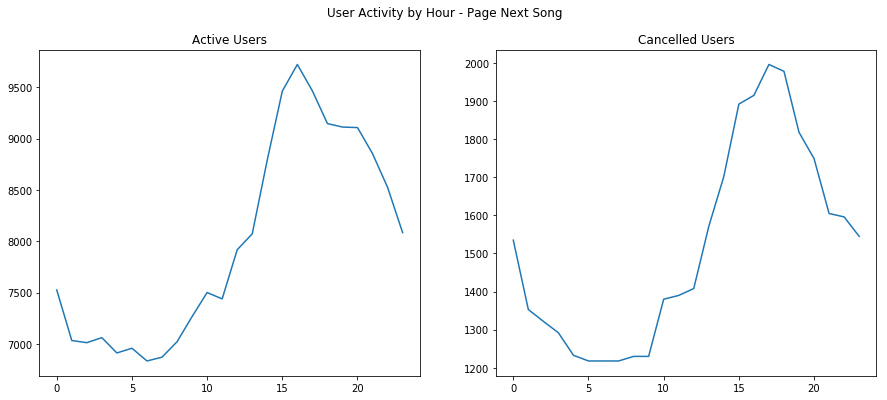

In [50]:
## Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page == 'NextSong').filter(df3.churn==0).groupBy(['access_hour']).count().\
sort('access_hour').toPandas()


df_bar_1 = df3.filter(df3.page == 'NextSong').filter(df3.churn==1).groupBy(['access_hour']).count().\
sort('access_hour').toPandas()



### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('User Activity by Hour - Page Next Song')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
#sns.barplot(x='access_hour', y='count', palette="Blues_d", data=df_bar_0)
plt.plot(df_bar_0['access_hour'], df_bar_0['count'])

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
#sns.barplot(x='access_hour', y='count', palette="Blues_d", data=df_bar_1)
plt.plot(df_bar_1['access_hour'], df_bar_1['count'])

plt.show()

***Obs***
Both curves present pretty much the same pattern

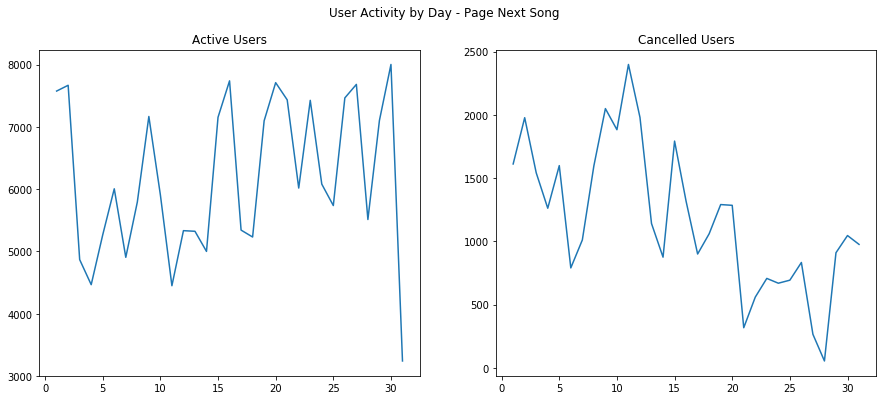

In [51]:
## Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page == 'NextSong').filter(df3.churn==0).groupBy(['access_day']).count().\
sort('access_day').toPandas()


df_bar_1 = df3.filter(df3.page == 'NextSong').filter(df3.churn==1).groupBy(['access_day']).count().\
sort('access_day').toPandas()



### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('User Activity by Day - Page Next Song')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
plt.plot(df_bar_0['access_day'], df_bar_0['count'])
#sns.barplot(x='access_day', y='count', palette="Blues_d", data=df_bar_0)

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
plt.plot(df_bar_1['access_day'], df_bar_1['count'])
#sns.barplot(x='access_day', y='count', palette="Blues_d", data=df_bar_1)

plt.show()

***Obs***
It is interesting to observe that how cancelled users are more active in the first 10 days of the month when compared to active users

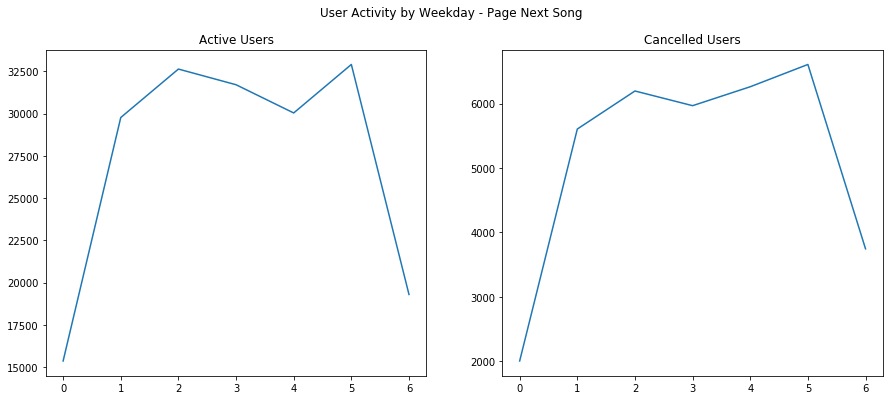

In [52]:
### Wrangling the data to be plotted
df_bar_0 = df3.filter(df3.page == 'NextSong').filter(df3.churn==0).groupBy(['access_weekday']).count().\
sort('access_weekday').toPandas()


df_bar_1 = df3.filter(df3.page == 'NextSong').filter(df3.churn==1).groupBy(['access_weekday']).count().\
sort('access_weekday').toPandas()



### Creating the canvas
fig = plt.figure(figsize=(15,6))
fig.suptitle('User Activity by Weekday - Page Next Song')

### Plotting active users
plt.subplot(121)
plt.title('Active Users')
plt.plot(df_bar_0['access_weekday'], df_bar_0['count'])
#sns.barplot(x='access_weekday', y='count', palette="Blues_d", data=df_bar_0)

### Plotting cancelled users
plt.subplot(122)
plt.title('Cancelled Users')
plt.plot(df_bar_1['access_weekday'], df_bar_1['count'])
#sns.barplot(x='access_weekday', y='count', palette="Blues_d", data=df_bar_1)

plt.show()

***Obs:***
Both curves present pretty much the same pattern

## 3 - Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### 3.1 - Creating Features

#### Feature 1 - Tagging genders

In [53]:
feat1 = df3.select('userId', 'gender').withColumn('gender_boolean',\
                                                   when((df3.gender == 'F'), lit('0')).\
                                                   when((df3.gender == 'M'), lit('1')).\
                                                   otherwise(lit('gender_not_detected')))


feat1 = feat1.select('userId', 'gender_boolean').sort('userId').dropDuplicates()

feat1.show(10)
print(f'The dataframe has {feat1.toPandas().shape[0]} rows and {feat1.toPandas().shape[1]} columns')
print(f"The dataframe has {feat1.toPandas()['userId'].nunique()} unique ID's")

+------+--------------+
|userId|gender_boolean|
+------+--------------+
|    10|             1|
|   100|             1|
|100001|             0|
|100002|             0|
|100003|             0|
|100004|             0|
|100005|             1|
|100006|             0|
|100007|             0|
|100008|             0|
+------+--------------+
only showing top 10 rows

The dataframe has 225 rows and 2 columns
The dataframe has 225 unique ID's


#### Feature 2 -  Number of songs listened by users

In [54]:
feat2 = df3.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
feat2 = feat2.sort('userId')
feat2.show(10)

print(f'The dataframe has {feat2.toPandas().shape[0]} rows and {feat2.toPandas().shape[1]} columns')
print(f"The dataframe has {feat2.toPandas()['userId'].nunique()} unique ID's")

+------+-----------+
|userId|total_songs|
+------+-----------+
|    10|        795|
|   100|       3214|
|100001|        187|
|100002|        218|
|100003|         78|
|100004|       1245|
|100005|        216|
|100006|         44|
|100007|        520|
|100008|        940|
+------+-----------+
only showing top 10 rows

The dataframe has 225 rows and 2 columns
The dataframe has 225 unique ID's


#### Feature 3 - Number of accesses to the Thumbs-up "page" 

In [55]:
feat3 = df3.select('userId', 'page').filter(df3.page == 'Thumbs Up').groupBy('userId').count().\
withColumnRenamed('count', 'page_thumbs-up')
feat3 = feat3.sort('userId')

feat3.show(10)
print(f'The dataframe has {feat3.toPandas().shape[0]} rows and {feat3.toPandas().shape[1]} columns')
print(f"The dataframe has {feat3.toPandas()['userId'].nunique()} unique ID's")

+------+--------------+
|userId|page_thumbs-up|
+------+--------------+
|    10|            37|
|   100|           148|
|100001|             8|
|100002|             5|
|100003|             3|
|100004|            35|
|100005|             7|
|100006|             2|
|100007|            19|
|100008|            37|
+------+--------------+
only showing top 10 rows

The dataframe has 220 rows and 2 columns
The dataframe has 220 unique ID's


#### Feature 4 - Number of accesses to the Home page

In [56]:
feat4 = df3.select('userId', 'page').filter(df3.page == 'Home').groupBy('userId').count().\
withColumnRenamed('count', 'page_home')
feat4 = feat4.sort('userId')

feat4.show(10)
print(f'The dataframe has {feat4.toPandas().shape[0]} rows and {feat4.toPandas().shape[1]} columns')
print(f"The dataframe has {feat4.toPandas()['userId'].nunique()} unique ID's")

+------+---------+
|userId|page_home|
+------+---------+
|    10|       30|
|   100|      105|
|100001|       11|
|100002|        6|
|100003|        7|
|100004|       66|
|100005|       15|
|100006|        2|
|100007|       20|
|100008|       24|
+------+---------+
only showing top 10 rows

The dataframe has 223 rows and 2 columns
The dataframe has 223 unique ID's


#### Feature 5 - Number of accesses to the Add to Playlist "page"

In [57]:
feat5 = df3.select('userId', 'page').filter(df3.page == 'Add to Playlist').groupBy('userId').count().\
withColumnRenamed('count', 'page_playlist')
feat5 = feat5.sort('userId')

feat5.show(10)
print(f'The dataframe has {feat5.toPandas().shape[0]} rows and {feat5.toPandas().shape[1]} columns')
print(f"The dataframe has {feat5.toPandas()['userId'].nunique()} unique ID's")

+------+-------------+
|userId|page_playlist|
+------+-------------+
|    10|            9|
|   100|           61|
|100001|            3|
|100002|            5|
|100003|            2|
|100004|           23|
|100005|            3|
|100006|            1|
|100007|            9|
|100008|           30|
+------+-------------+
only showing top 10 rows

The dataframe has 215 rows and 2 columns
The dataframe has 215 unique ID's


#### Feature 6 - Number of accesses to the  Add Friend "page"

In [58]:
feat6 = df3.select('userId', 'page').filter(df3.page == 'Add Friend').groupBy('userId').count().\
withColumnRenamed('count', 'page_add_friend')
feat6 = feat6.sort('userId')

feat6.show(10)
print(f'The dataframe has {feat6.toPandas().shape[0]} rows and {feat6.toPandas().shape[1]} columns')
print(f"The dataframe has {feat6.toPandas()['userId'].nunique()} unique ID's")

+------+---------------+
|userId|page_add_friend|
+------+---------------+
|    10|             12|
|   100|             49|
|100001|              2|
|100002|              1|
|100004|             19|
|100005|              3|
|100006|              4|
|100007|             17|
|100008|             17|
|100009|              7|
+------+---------------+
only showing top 10 rows

The dataframe has 206 rows and 2 columns
The dataframe has 206 unique ID's


#### Feature 7 - Number of accesses to the Roll Advert page

In [59]:
feat7 = df3.select('userId', 'page').filter(df3.page == 'Roll Advert').groupBy('userId').count().\
withColumnRenamed('count', 'page_roll_advert')

feat7 = feat7.sort('userId')
feat7.show(10)
print(f'The dataframe has {feat7.toPandas().shape[0]} rows and {feat7.toPandas().shape[1]} columns')
print(f"The dataframe has {feat7.toPandas()['userId'].nunique()} unique ID's")

+------+----------------+
|userId|page_roll_advert|
+------+----------------+
|    10|               1|
|   100|              25|
|100001|              14|
|100002|               3|
|100003|               9|
|100004|              86|
|100005|              18|
|100006|               3|
|100007|               5|
|100008|              20|
+------+----------------+
only showing top 10 rows

The dataframe has 207 rows and 2 columns
The dataframe has 207 unique ID's


#### Feature 8 - Number of accesses to the Logout "page"

In [60]:
feat8 = df3.select('userId', 'page').filter(df3.page == 'Logout').groupBy('userId').count().\
withColumnRenamed('count', 'page_logout')

feat8 = feat8.sort('userId')
feat8.show(10)
print(f'The dataframe has {feat8.toPandas().shape[0]} rows and {feat8.toPandas().shape[1]} columns')
print(f"The dataframe has {feat8.toPandas()['userId'].nunique()} unique ID's")

+------+-----------+
|userId|page_logout|
+------+-----------+
|    10|         11|
|   100|         35|
|100001|          7|
|100002|          1|
|100003|          3|
|100004|         19|
|100005|          3|
|100006|          1|
|100007|          5|
|100008|          7|
+------+-----------+
only showing top 10 rows

The dataframe has 213 rows and 2 columns
The dataframe has 213 unique ID's


#### Feature 9 - Number of accesses to the  Thumbs-down "page"

In [61]:
feat9 = df3.select('userId', 'page').filter(df3.page == 'Thumbs Down').groupBy('userId').count().\
withColumnRenamed('count', 'page_thumbs-down')
feat9 = feat9.sort('userId')

feat9.show(10)
print(f'The dataframe has {feat9.toPandas().shape[0]} rows and {feat9.toPandas().shape[1]} columns')
print(f"The dataframe has {feat9.toPandas()['userId'].nunique()} unique ID's")

+------+----------------+
|userId|page_thumbs-down|
+------+----------------+
|    10|               4|
|   100|              27|
|100001|               2|
|100004|              11|
|100005|               3|
|100006|               2|
|100007|               6|
|100008|               6|
|100009|               8|
|100010|               5|
+------+----------------+
only showing top 10 rows

The dataframe has 203 rows and 2 columns
The dataframe has 203 unique ID's


#### Feature 10 - Number of accesses to the  Downgrade "page"

In [62]:
feat10 = df3.select('userId', 'page').filter(df3.page == 'Downgrade').groupBy('userId').count().\
withColumnRenamed('count', 'page_downgrade')
feat10 = feat10.sort('userId')

feat10.show(10)
print(f'The dataframe has {feat10.toPandas().shape[0]} rows and {feat10.toPandas().shape[1]} columns')
print(f"The dataframe has {feat10.toPandas()['userId'].nunique()} unique ID's")

+------+--------------+
|userId|page_downgrade|
+------+--------------+
|    10|             7|
|   100|            30|
|100002|             2|
|100004|            10|
|100007|             7|
|100008|            10|
|100009|             5|
|100012|             4|
|100013|            13|
|100014|             3|
+------+--------------+
only showing top 10 rows

The dataframe has 154 rows and 2 columns
The dataframe has 154 unique ID's


#### Feature 11 - Number of accesses to the help page

In [63]:
feat11 = df3.select('userId', 'page').filter(df3.page == 'Help').groupBy('userId').count().\
withColumnRenamed('count', 'page_help')
feat11 = feat11.sort('userId')

feat11.show(10)
print(f'The dataframe has {feat11.toPandas().shape[0]} rows and {feat11.toPandas().shape[1]} columns')
print(f"The dataframe has {feat11.toPandas()['userId'].nunique()} unique ID's")

+------+---------+
|userId|page_help|
+------+---------+
|    10|        1|
|   100|       18|
|100001|        1|
|100003|        1|
|100004|        6|
|100005|        2|
|100007|        3|
|100008|        6|
|100009|        6|
|100010|        2|
+------+---------+
only showing top 10 rows

The dataframe has 192 rows and 2 columns
The dataframe has 192 unique ID's


#### Feature 12 - Total Time Spent by the user in the platform

In [64]:
df3 = df3.na.fill(value=0,subset=['length'])
feat12 = df3.select('userId', 'length').groupBy('userId').agg({'length': 'sum'}).\
withColumnRenamed('sum(length)', 'total_length')
feat12 = feat12.sort('userId')

feat12.show(10)
print(f'The dataframe has {feat12.toPandas().shape[0]} rows and {feat12.toPandas().shape[1]} columns')
print(f"The dataframe has {feat12.toPandas()['userId'].nunique()} unique ID's")

+------+------------------+
|userId|      total_length|
+------+------------------+
|    10|166866.37251000004|
|   100|  672877.856590001|
|100001|35073.742150000005|
|100002| 49559.91809999999|
|100003|12306.419320000003|
|100004|231480.38928999988|
|100005| 37037.12201000001|
|100006|        5854.89105|
|100007|104495.32492000007|
|100008|191396.79601999995|
+------+------------------+
only showing top 10 rows

The dataframe has 225 rows and 2 columns
The dataframe has 225 unique ID's


#### Feature 13 - Total number of artists per user

In [65]:
feat13 = df3.select('userId', 'artist').filter(df3.page == 'NextSong').groupBy(['userId', 'artist']).count()
feat13= feat13.select('userId', 'artist').groupBy(['userId']).count().withColumnRenamed('count', 'artists_per_user')
feat13 = feat13.sort('userId')

feat13.show(10)
print(f'The dataframe has {feat13.toPandas().shape[0]} rows and {feat13.toPandas().shape[1]} columns')
print(f"The dataframe has {feat13.toPandas()['userId'].nunique()} unique ID's")

+------+----------------+
|userId|artists_per_user|
+------+----------------+
|    10|             565|
|   100|            1705|
|100001|             125|
|100002|             184|
|100003|              50|
|100004|             733|
|100005|             149|
|100006|              26|
|100007|             357|
|100008|             623|
+------+----------------+
only showing top 10 rows

The dataframe has 225 rows and 2 columns
The dataframe has 225 unique ID's


#### Feature 14 - Maximum number of days for a single registration

In [66]:
feat14 = df3.select('userId', 'registration', 'ts')
feat14 = feat14.withColumn('registration_date', time_stamp(feat14.registration))
feat14 = feat14.withColumn('ts_date', time_stamp(feat14.ts))
feat14 = feat14.select('userId', 'registration_date', 'ts_date', datediff('ts_date','registration_date').\
                       alias('days_difference'))

feat14 = feat14.select('userId', 'days_difference').groupBy('userId').agg({'days_difference': 'max'}).\
withColumnRenamed('max(days_difference)', 'max_days_registered').sort('userId')


feat14.show(10)
print(f'The dataframe has {feat14.toPandas().shape[0]} rows and {feat14.toPandas().shape[1]} columns')
print(f"The dataframe has {feat14.toPandas()['userId'].nunique()} unique ID's")

+------+-------------------+
|userId|max_days_registered|
+------+-------------------+
|    10|                 52|
|   100|                 65|
|100001|                 45|
|100002|                161|
|100003|                 23|
|100004|                173|
|100005|                 85|
|100006|                  9|
|100007|                115|
|100008|                 68|
+------+-------------------+
only showing top 10 rows

The dataframe has 225 rows and 2 columns
The dataframe has 225 unique ID's


#### Feature 15 - Total number of songs listened per session

In [67]:
feat15 = df3.select('userId', 'sessionId', 'page').filter(df3.page == 'NextSong').groupBy(['userId', 'sessionId']).count()

feat15 = feat15.select('userId', 'count').groupby(['userId']).mean().\
withColumnRenamed('avg(count)', 'mean_songs_temp')

feat15 = feat15.withColumn('mean_number_of_songs', feat15.mean_songs_temp.cast('int'))
feat15 = feat15.select('userId', 'mean_number_of_songs').sort('userId')


feat15.show(10)
print(f'The dataframe has {feat15.toPandas().shape[0]} rows and {feat15.toPandas().shape[1]} columns')
print(f"The dataframe has {feat15.toPandas()['userId'].nunique()} unique ID's")

+------+--------------------+
|userId|mean_number_of_songs|
+------+--------------------+
|    10|                 112|
|   100|                  78|
|100001|                  33|
|100002|                  48|
|100003|                  25|
|100004|                  47|
|100005|                  38|
|100006|                  26|
|100007|                  47|
|100008|                 128|
+------+--------------------+
only showing top 10 rows

The dataframe has 225 rows and 2 columns
The dataframe has 225 unique ID's


#### Selecting the churn column - dependent variable

In [68]:
df_churn = df_spark.select('userId', 'churn')
df_churn.show(10)
print(f"The dataframe has {df_churn.toPandas()['userId'].nunique()} unique ID's")

+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
+------+-----+
only showing top 10 rows

The dataframe has 225 unique ID's


### 3.2 - Creating a single dataframe with all features

In [69]:
final_data = feat1.join(feat2, 'userId', 'left').\
                   join(feat3, 'userId', 'left').\
                   join(feat4, 'userId', 'left').\
                   join(feat5, 'userId', 'left').\
                   join(feat6, 'userId', 'left').\
                   join(feat7, 'userId', 'left').\
                   join(feat8, 'userId', 'left').\
                   join(feat9, 'userId', 'left').\
                   join(feat10, 'userId', 'left').\
                   join(feat11, 'userId', 'left').\
                   join(feat12, 'userId', 'left').\
                   join(feat13, 'userId', 'left').\
                   join(feat14, 'userId', 'left').\
                   join(feat15, 'userId', 'left').\
                   join(df_churn, 'userId', 'left').\
                   sort('userId')


final_data.toPandas().head(5)

,userId,gender_boolean,total_songs,page_thumbs-up,page_home,page_playlist,page_add_friend,page_roll_advert,page_logout,page_thumbs-down,page_downgrade,page_help,total_length,artists_per_user,max_days_registered,mean_number_of_songs,churn
0,10,1,795,37.0,30.0,9.0,12.0,1.0,11.0,4.0,7.0,1.0,166866.37251,565,52,112,0
1,100,1,3214,148.0,105.0,61.0,49.0,25.0,35.0,27.0,30.0,18.0,672877.85659,1705,65,78,0
2,100001,0,187,8.0,11.0,3.0,2.0,14.0,7.0,2.0,NaN,1.0,35073.74215,125,45,33,1
3,100002,0,218,5.0,6.0,5.0,1.0,3.0,1.0,NaN,2.0,NaN,49559.91810,184,161,48,0
4,100003,0,78,3.0,7.0,2.0,NaN,9.0,3.0,NaN,NaN,1.0,12306.41932,50,23,25,1


### 3.3 - Replacing nan with zeros for the pages

In [70]:
pages = ['page_thumbs-up', 'page_home', 'page_playlist', 'page_add_friend', 'page_roll_advert',
         'page_logout', 'page_thumbs-down', 'page_downgrade', 'page_help']


final_data = final_data.na.fill(value=0, subset=pages)

### 3.4 - Checking the number of nulls for each column

In [71]:
for i in final_data.columns:
    n_nulls = final_data.toPandas()[i].isnull().sum()
    print(f'The colunm {i} has {n_nulls} null values')

The colunm userId has 0 null values
The colunm gender_boolean has 0 null values
The colunm total_songs has 0 null values
The colunm page_thumbs-up has 0 null values
The colunm page_home has 0 null values
The colunm page_playlist has 0 null values
The colunm page_add_friend has 0 null values
The colunm page_roll_advert has 0 null values
The colunm page_logout has 0 null values
The colunm page_thumbs-down has 0 null values
The colunm page_downgrade has 0 null values
The colunm page_help has 0 null values
The colunm total_length has 0 null values
The colunm artists_per_user has 0 null values
The colunm max_days_registered has 0 null values
The colunm mean_number_of_songs has 0 null values
The colunm churn has 0 null values


In [72]:
### Checking the data after the changes
print(f'The dataframe has {final_data.toPandas().shape[0]} rows and {final_data.toPandas().shape[1]} columns')
print(f"The dataframe has {final_data.toPandas()['userId'].nunique()} unique ID's")
      
final_data.toPandas().head(5)

The dataframe has 225 rows and 17 columns
The dataframe has 225 unique ID's


,userId,gender_boolean,total_songs,page_thumbs-up,page_home,page_playlist,page_add_friend,page_roll_advert,page_logout,page_thumbs-down,page_downgrade,page_help,total_length,artists_per_user,max_days_registered,mean_number_of_songs,churn
0,10,1,795,37,30,9,12,1,11,4,7,1,166866.37251,565,52,112,0
1,100,1,3214,148,105,61,49,25,35,27,30,18,672877.85659,1705,65,78,0
2,100001,0,187,8,11,3,2,14,7,2,0,1,35073.74215,125,45,33,1
3,100002,0,218,5,6,5,1,3,1,0,2,0,49559.91810,184,161,48,0
4,100003,0,78,3,7,2,0,9,3,0,0,1,12306.41932,50,23,25,1


### 3.5 - Converting all columns to numerical

In [73]:
final_data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender_boolean: string (nullable = false)
 |-- total_songs: long (nullable = true)
 |-- page_thumbs-up: long (nullable = true)
 |-- page_home: long (nullable = true)
 |-- page_playlist: long (nullable = true)
 |-- page_add_friend: long (nullable = true)
 |-- page_roll_advert: long (nullable = true)
 |-- page_logout: long (nullable = true)
 |-- page_thumbs-down: long (nullable = true)
 |-- page_downgrade: long (nullable = true)
 |-- page_help: long (nullable = true)
 |-- total_length: double (nullable = true)
 |-- artists_per_user: long (nullable = true)
 |-- max_days_registered: integer (nullable = true)
 |-- mean_number_of_songs: integer (nullable = true)
 |-- churn: long (nullable = true)



In [74]:
final_data = final_data.\
withColumn('userId', final_data.userId.cast('int')).\
withColumn('gender_boolean', final_data.gender_boolean.cast('int')).\
withColumn('artists_per_user', final_data.artists_per_user.cast('int'))

final_data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- gender_boolean: integer (nullable = true)
 |-- total_songs: long (nullable = true)
 |-- page_thumbs-up: long (nullable = true)
 |-- page_home: long (nullable = true)
 |-- page_playlist: long (nullable = true)
 |-- page_add_friend: long (nullable = true)
 |-- page_roll_advert: long (nullable = true)
 |-- page_logout: long (nullable = true)
 |-- page_thumbs-down: long (nullable = true)
 |-- page_downgrade: long (nullable = true)
 |-- page_help: long (nullable = true)
 |-- total_length: double (nullable = true)
 |-- artists_per_user: integer (nullable = true)
 |-- max_days_registered: integer (nullable = true)
 |-- mean_number_of_songs: integer (nullable = true)
 |-- churn: long (nullable = true)



### 3.6 -Vectorizing the data

In [75]:
### Selecting columns to be normalized
features_cols = final_data.columns
features_cols.remove('userId')
features_cols.remove('churn')
features_cols

['gender_boolean',
 'total_songs',
 'page_thumbs-up',
 'page_home',
 'page_playlist',
 'page_add_friend',
 'page_roll_advert',
 'page_logout',
 'page_thumbs-down',
 'page_downgrade',
 'page_help',
 'total_length',
 'artists_per_user',
 'max_days_registered',
 'mean_number_of_songs']

In [76]:
### Instantiating the Vector Assembler and thranforming the data
assembler = VectorAssembler(inputCols=features_cols, outputCol='vec_features')
final_data = assembler.transform(final_data)

### 3.7 - Scaling the data

In [77]:
scaler = StandardScaler(inputCol='vec_features', outputCol='features', withStd=True)
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)
final_data.toPandas().head()

,userId,gender_boolean,total_songs,page_thumbs-up,page_home,page_playlist,page_add_friend,page_roll_advert,page_logout,page_thumbs-down,page_downgrade,page_help,total_length,artists_per_user,max_days_registered,mean_number_of_songs,churn,vec_features,features
0,10,1,795,37,30,9,12,1,11,4,7,1,166866.37251,565,52,112,0,"[1.0, 795.0, 37.0, 30.0, 9.0, 12.0, 1.0, 11.0,...","[2.00127105192, 0.597954896581, 0.565075943089..."
1,100,1,3214,148,105,61,49,25,35,27,30,18,672877.85659,1705,65,78,0,"[1.0, 3214.0, 148.0, 105.0, 61.0, 49.0, 25.0, ...","[2.00127105192, 2.41739250014, 2.26030377236, ..."
2,100001,0,187,8,11,3,2,14,7,2,0,1,35073.74215,125,45,33,1,"[0.0, 187.0, 8.0, 11.0, 3.0, 2.0, 14.0, 7.0, 2...","[0.0, 0.140651025988, 0.12217858229, 0.2325772..."
3,100002,0,218,5,6,5,1,3,1,0,2,0,49559.91810,184,161,48,0,"[0.0, 218.0, 5.0, 6.0, 5.0, 1.0, 3.0, 1.0, 0.0...","[0.0, 0.163967506232, 0.076361613931, 0.126860..."
4,100003,0,78,3,7,2,0,9,3,0,0,1,12306.41932,50,23,25,1,"[0.0, 78.0, 3.0, 7.0, 2.0, 0.0, 9.0, 3.0, 0.0,...","[0.0, 0.0586672728721, 0.0458169683586, 0.1480..."


### 3.8 - Selecting the columns to be trained and tested

In [78]:
model_data = final_data.select('features', 'churn').withColumnRenamed('churn', 'label')
model_data.show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.00127105192366...|    0|
|[2.00127105192366...|    0|
|[0.0,0.1406510259...|    1|
|[0.0,0.1639675062...|    0|
|[0.0,0.0586672728...|    1|
|[0.0,0.9364199323...|    0|
|[2.00127105192366...|    1|
|[0.0,0.0330943590...|    1|
|[0.0,0.3911151524...|    1|
|[0.0,0.7070158525...|    0|
+--------------------+-----+
only showing top 10 rows



***Obs:*** After all the wrangling and preparation, the dataset is ready to be trained and tested 

## 4 - Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 4.1 - Defining training and testing sets - 80% of the data for training, 20% for testing

In [79]:
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=50)

### 4.2 Creating the Model Evaluator

In [80]:
model_evaluator = MulticlassClassificationEvaluator(metricName='f1')

### 4.3 - Defining, Applyng and Evaluating the Models

#### 4.3.1 - Logistic Regression

In [81]:
### Instantiating the model
log_reg = LogisticRegression()

### Defining the model's parameter grid
paramGrid_log_reg = ParamGridBuilder().\
                    addGrid(log_reg.regParam, [0.0, 0.05, 0.1]).\
                    addGrid(log_reg.maxIter, [10, 50]).\
                    build()

### Defining the Cross Validator
crossval_log_reg = CrossValidator(estimator=log_reg,
                                  estimatorParamMaps=paramGrid_log_reg,
                                  evaluator=model_evaluator,
                                  numFolds=3)

### Fitting the model
log_reg_model = crossval_log_reg.fit(train_data)

### Saving the model
log_reg_model.write().overwrite().save('log_reg_model')

#### Evaluating the model

In [82]:
log_reg_preds = log_reg_model.transform(test_data)
log_reg_f1 = model_evaluator.evaluate(log_reg_preds)
print(f'F-Score Logistic Regression: {log_reg_f1}')

F-Score Logistic Regression: 0.8572649572649573


#### Loading and Evaluating the saved model

In [83]:
### Loading the model
log_reg_loaded_model = log_reg_model.load('log_reg_model')


### Evaluating the loaded model
log_reg_preds = log_reg_loaded_model.bestModel.transform(test_data)
log_reg_f1 = model_evaluator.evaluate(log_reg_preds)
print(f'F-Score Logistic Regression: {log_reg_f1}')

F-Score Logistic Regression: 0.8572649572649573


#### 4.3.2 - Support Vector Machines

In [84]:
### Instantiating the model
svm = LinearSVC()

### Defining the model's parameter grid
paramGrid_svm = ParamGridBuilder().\
                addGrid(svm.regParam, [0.01, 0.05, 0.1]).\
                addGrid(svm.maxIter, [5, 10]).\
                build()

### Defining the Cross Validator
crossval_svm = CrossValidator(estimator=svm,
                              estimatorParamMaps=paramGrid_svm,
                              evaluator=model_evaluator,
                              numFolds=3)

### Fitting the model
svm_model = crossval_svm.fit(train_data)


### Saving the model
svm_model.write().overwrite().save('svm_model')

#### Evaluating the model

In [85]:
svm_preds = svm_model.transform(test_data)
svm_f1 = model_evaluator.evaluate(svm_preds)
print(f'F-Score Support Vector Machines: {svm_f1}')

F-Score Support Vector Machines: 0.7732262382864792


#### Loading and Evaluating the saved model

In [86]:
### Loading the model
svm_loaded_model = svm_model.load('svm_model')


### Scoring the data using the model
svm_preds = svm_loaded_model.bestModel.transform(test_data)
svm_f1 = model_evaluator.evaluate(svm_preds)
print(f'F-Score Support Vector Machines: {svm_f1}')

F-Score Support Vector Machines: 0.7732262382864792


#### 4.3.3 - Decision Trees

In [87]:
### Instantiating the model
dec_tree = DecisionTreeClassifier()

### Defining the model's parameter grid
paramGrid_dec_tree = ParamGridBuilder().\
                     addGrid(dec_tree.impurity, ['entropy', 'gini']).\
                     addGrid(dec_tree.maxDepth, [2, 4, 5, 10, 12, 15]).\
                     build()

### Defining the Cross Validator
crossval_dec_tree = CrossValidator(estimator=dec_tree,
                                   estimatorParamMaps=paramGrid_dec_tree,
                                   evaluator=model_evaluator,
                                   numFolds=3)

### Fitting the model
dec_tree_model = crossval_dec_tree.fit(train_data)


### Saving the model
dec_tree_model.write().overwrite().save('dec_tree_model')

#### Evaluating the model

In [88]:
dec_tree_preds = dec_tree_model.transform(test_data)
dec_tree_f1 = model_evaluator.evaluate(dec_tree_preds)
print(f'F-Score Decision Trees: {dec_tree_f1}')

F-Score Decision Trees: 0.7268635724331927


#### Loading and Evaluating the saved model

In [89]:
### Loading the model
dec_tree_loaded_model = dec_tree_model.load('dec_tree_model')


### Scoring the data using the model
dec_tree_preds2 = dec_tree_loaded_model.bestModel.transform(test_data)
dec_tree_f12 = model_evaluator.evaluate(dec_tree_preds2)
print(f'F-Score Decision Trees: {dec_tree_f12}')

F-Score Decision Trees: 0.7268635724331927


#### 4.3.4 - Random Forest

In [90]:
### Instantiating the model
rf = RandomForestClassifier()

### Defining the model's parameter grid
paramGrid_rf = ParamGridBuilder().\
               addGrid(rf.numTrees, [10, 30]).\
               addGrid(rf.maxDepth, [5, 10]).\
               build()

### Defining the Cross Validator
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=model_evaluator,
                             numFolds=3)

### Fitting the model
rf_model = crossval_rf.fit(train_data)


### Saving the model
rf_model.write().overwrite().save('rf_model')

#### Evaluating the model

In [91]:
rf_preds = rf_model.transform(test_data)
rf_f1 = model_evaluator.evaluate(rf_preds)
print(f'F-Score Random Forest: {rf_f1}')

F-Score Random Forest: 0.8096866096866097


#### Loading and Evaluating the saved model

In [92]:
### Loading the model
rf_loaded_model = rf_model.load('rf_model')


### Scoring the data using the model
rf_preds = rf_loaded_model.bestModel.transform(test_data)
rf_f1 = model_evaluator.evaluate(rf_preds)
print(f'F-Score Random Forest: {rf_f1}')

F-Score Random Forest: 0.8096866096866097


#### 4.3.5 - Gradient Boosted Trees

In [93]:
### Instantiating the model
gbt = GBTClassifier()

### Defining the model's parameter grid
paramGrid_gbt = ParamGridBuilder().\
                addGrid(gbt.maxDepth, [5, 10]).\
                addGrid(gbt.maxIter, [4, 6, 8]).\
                build()

### Defining the Cross Validator
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=model_evaluator,
                              numFolds=3)

### Fitting the model
gbt_model = crossval_gbt.fit(train_data)


### Saving the model
gbt_model.write().overwrite().save('gbt_model')

#### Evaluating the model

In [94]:
gbt_preds = gbt_model.transform(test_data)
gbt_f1 = model_evaluator.evaluate(gbt_preds)
print(f'F-Score Gradient Boosted Trees: {gbt_f1}')

F-Score Gradient Boosted Trees: 0.6987892265875958


#### Loading and Evaluating the saved model

In [95]:
### Loading the model
gbt_loaded_model = gbt_model.load('gbt_model')


### Scoring the data using the model
gbt_preds = gbt_loaded_model.bestModel.transform(test_data)
gbt_f1 = model_evaluator.evaluate(gbt_preds)
print(f'F-Score Gradient Boosted Trees: {gbt_f1}')

F-Score Gradient Boosted Trees: 0.6987892265875958


### 4.3 - Comparing F-Scores

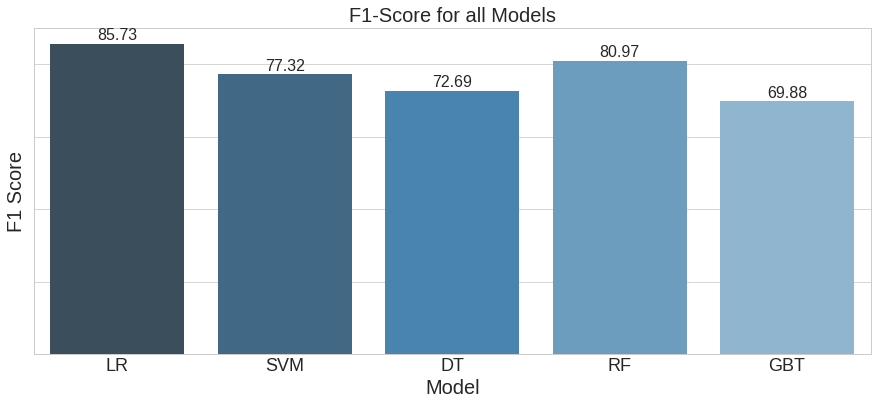

In [96]:
### Editing and Storing the scores for each model
a = round(log_reg_f1*100, 2)
b = round(svm_f1*100, 2)
c = round(dec_tree_f1*100, 2)
d = round(rf_f1*100, 2)
e = round(gbt_f1*100, 2)



### Plotting the Scores
names = ['LR', 'SVM', 'DT', 'RF', 'GBT']
values = [a, b, c, d, e]

fig = plt.figure(figsize=(15,6))
plt.style.use('seaborn-whitegrid')
plt.title('F1-Score for all Models', size=20)
plt.xlabel('Model', size=20)
plt.ylabel('F1 Score', size=20)
bar = sns.barplot(x=names, y=values, palette='Blues_d')
bar.set_xticklabels(bar.get_xmajorticklabels(), fontsize = 18)
bar.set_yticklabels(bar.get_ymajorticklabels(), fontsize = 18)

for p in bar.patches:
    bar.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', size =16,
                   xytext = (0, 8), 
                   textcoords = 'offset points')

plt.show()

### 4.4 - Feature Importance - Extracting coefficients

In [97]:
### Extracting and saving the coefficients values in a list
scores = list(log_reg_model.bestModel.coefficients)

In [98]:
len(scores)

15

In [99]:
len(features_cols)

15

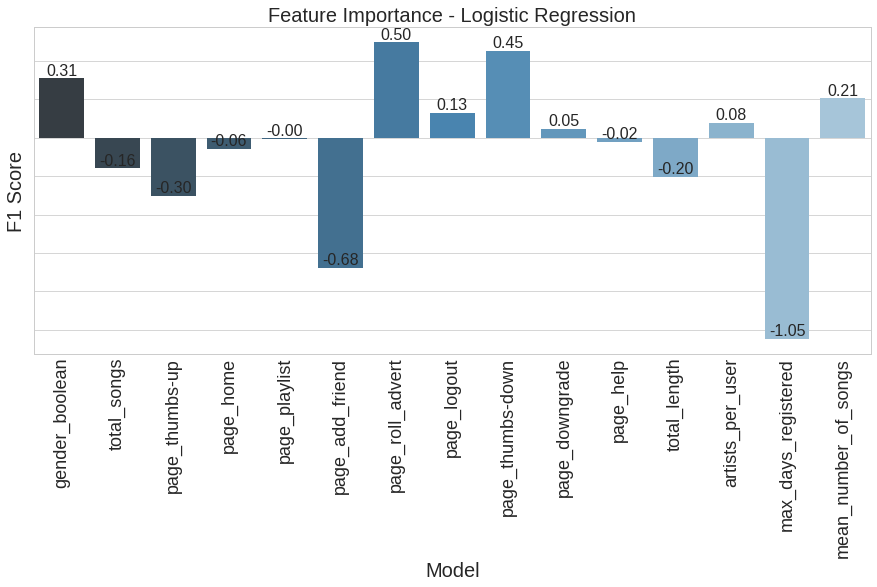

In [101]:
### Plotting coefficients
fig = plt.figure(figsize=(15,6))
plt.style.use('seaborn-whitegrid')
plt.title('Feature Importance - Logistic Regression', size=20)
plt.xlabel('Model', size=20)
plt.ylabel('F1 Score', size=20)
plt.xticks(rotation=90)
bar = sns.barplot(x=features_cols, y=scores, palette='Blues_d')
bar.set_xticklabels(bar.get_xmajorticklabels(), fontsize = 18)
bar.set_yticklabels(bar.get_ymajorticklabels(), fontsize = 18)

for p in bar.patches:
    bar.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', size =16,
                   xytext = (0, 8), 
                   textcoords = 'offset points')

plt.show()

## 5 - Conclusions

The Logistic Regression model has the highest F-Score (85.73%).

When it comes to Feature Importance, as seen in the chart, the following features have more impact in predicting churn:

***max_days_registered:*** -1.05
<br/>
<br/>
***page_add_friend:*** -0.68
<br/>
<br/>
***page_roll_advert:*** 0.50
<br/>
<br/>
***page_thumbs_down:*** 0.45
<br/>
<br/>
***gender_boolean:*** 0.31
<br/>
<br/>
***page_thumbs-up:*** -0.30

It seems that, the longer a customer uses the platform and the more friends he has, the more likely it is for him/her to stay.

In addition, it is interesting to observe that the more a customer clicks on thumbs-down, the more likely he/she will cancel his/her account.

Despite the fact that the model has a high F-1 Score, we have worked with a small dataset. Working with a larger dataset is one way of tuning the model.

Another way of achieving it is to create more features, like geographical data, educational level, age and income (if the user has it). With these new features in hand, we could do some more feature engineering, creating new features, improving data quality and, eventually, helping predict user churn more accurately.

We can also tune the hyperparameters to improve model accuracy. However, we run the risk of spending too long training the model.

This is a good start, but more can be done to deliver a more accurate model, which will help Sparkify predict customer churn and act on it.

## 6 - Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## 7 - Blog Post

Blog post on [Medium](https://paulo-toscano.medium.com/please-dont-go-1af39f0f7376) describing this project